In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
engagement = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')

## Finding Adopted Users

In [3]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


An  "adopted  user"   is  a  user  who   has  logged  into  the  product  on  three  separate days  in  at  least  one  seven-day  period. We start from a list of individual login dates for each user. On inspection we find that each user has only one "visited" event per time_stamp.

In [4]:
engagement.time_stamp = pd.DatetimeIndex(engagement.time_stamp)
engagement = engagement.set_index('time_stamp').sort_index()
engagement.head()

,user_id,visited
time_stamp,,
2012-05-31 08:20:06,10012,1
2012-05-31 15:47:36,3428,1
2012-05-31 17:19:37,9899,1
2012-05-31 21:58:33,1693,1
2012-06-01 00:17:30,6102,1


We can recast our time_stamp field as a DatetimeIndex in pandas, allowing us to do rolling aggregates on the resulting data frame.

In [5]:
engagement_7d = (engagement
                 .groupby('user_id')
                 .visited.rolling('7D')
                 .sum())

adopted_users = (engagement_7d.groupby('user_id').max() > 3).reset_index()
adopted_users.columns = ['user_id', 'adopted']

adopted_users.head()

,user_id,adopted
0,1,False
1,2,False
2,3,False
3,4,False
4,5,False


We first get the sum of visits in each 7-day period by user_id, then find the maximum value for each user in our group. The resulting dataframe gives us the adopted user status for each user. This vector will serve as our outcome of interest in the prediction step.

## Data Curation

In [6]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


The users table has 12,000 individual users, while the outcome of whether a user is an adopted user or not is limited to roughly 8,800 individuals. 

In [7]:
data = adopted_users.merge(users, left_on='user_id', right_on='object_id')
data.head()

,user_id,adopted,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,False,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,False,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,False,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,False,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,False,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


We collapse the dataset down to users who have adoption information and incorporate our training data into this dataset in order to make sure that the ordering of our cells matches.

In [8]:
data = data.drop(['name', 'object_id', 'user_id', 'invited_by_user_id', 'org_id'], axis=1)

We can start by dropping a few columns that will be difficult to train using a ML classifier. Fields like user name and the user ID of the user or the person inviting the user will be difficult to encode as meaningful categorical variables. 

Investigating org_id showed it to have too many levels distributed too widely (roughly 400 organizations). Because it appeared difficult to code and to discern actionable information from this variable, it was also dropped.

### Email Information

In [9]:
emails = data.email.str.extract(r'.+\@(.+)')
print(emails.head())

           0
0  yahoo.com
1  gustr.com
2  gustr.com
3  yahoo.com
4  yahoo.com


We may wish to investigate the email service that users are engaging with as a potential predictor. We can extract the domain information.

In [10]:
print('\nnumber of emails with >5 users: %d' % sum(emails[0].value_counts() > 5))


number of emails with >5 users: 6


Only six email addresses have more than five users. This is a tractable amount to form a one-hot-encoded variable.

In [11]:
emails = emails[0]
emails.value_counts().head(6)

gmail.com         2930
yahoo.com         1726
jourrapide.com     883
gustr.com          842
cuvox.de           828
hotmail.com        803
Name: 0, dtype: int64

In [12]:
email_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'gustr.com', 'cuvox.de', 'hotmail.com']
is_other = ~emails.isin(email_domains)
sum(is_other)

811

We can see that around 10% of the dataset has an email not represented by our list of six major emails. 

In [13]:
emails.loc[is_other] = 'other'
emails.value_counts()
email_dummies = pd.get_dummies(emails)

We can code these values as a grouped "other" category and create a one-hot-encoded data frame.

### Creation Source

In [14]:
data.creation_source.value_counts()

ORG_INVITE            3188
SIGNUP                1898
GUEST_INVITE          1588
SIGNUP_GOOGLE_AUTH    1385
PERSONAL_PROJECTS      764
Name: creation_source, dtype: int64

In [15]:
creation_source = pd.get_dummies(data.creation_source)

The creation_source column is perfectly suited to conversion into a one-hot-encoded variable.

### Last Session Creation

In [16]:
data.last_session_creation_time = pd.to_datetime(data.last_session_creation_time, unit='s')
data.last_session_creation_time.head()

0   2014-04-22 03:53:30
1   2014-03-31 03:45:04
2   2013-03-19 23:14:52
3   2013-05-22 08:09:28
4   2013-01-22 10:14:20
Name: last_session_creation_time, dtype: datetime64[ns]

We first convert the timestamp data from Unix epoch time to datetime.

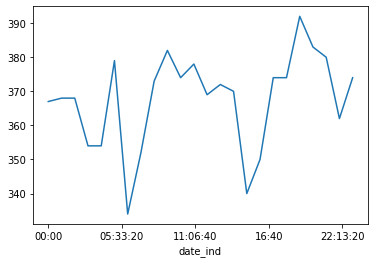

In [17]:
# Format to 1-hour increments
created = pd.DataFrame({'date_ind': data.last_session_creation_time})
created['session'] = 1
created.date_ind = pd.DatetimeIndex(created.date_ind)
created = created.set_index('date_ind')
created = created.groupby(pd.Grouper(freq='60min')).sum()

# Reformat to aggregate of visits in this period
created = created.reset_index()
created.date_ind = created.date_ind.dt.time
created_hourly = created.groupby('date_ind').session.sum()
created_hourly.plot()

There aren't strong trends that seem to jump out for the creation time of last session. There are dips in usage at late night hours and during mid-afternoon. It is possible that this fied may contain information about the usage patterns of users so we may wish to retain it.

In [18]:
'session creation (min/max): %s/%s' % (data.last_session_creation_time.min(), data.last_session_creation_time.max())

'session creation (min/max): 2012-05-31 08:20:06/2014-06-06 14:58:50'

We can see that this data spans two years. It may be useful to look at seasonal trends and longer term trends.

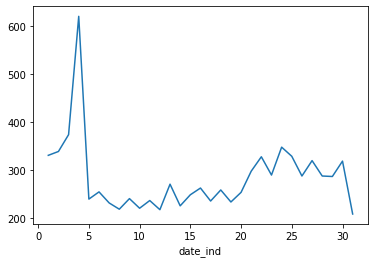

In [19]:
created_daily = pd.DataFrame({'date_ind': data.last_session_creation_time})
created_daily['sessions'] = 1
created_daily.date_ind = created_daily.date_ind.dt.day
created_daily.groupby('date_ind').sessions.sum().plot()

Interestingly we can see there is a large spike of signups evident early in the month. Time of month of last session may be a useful predictor of behavior.

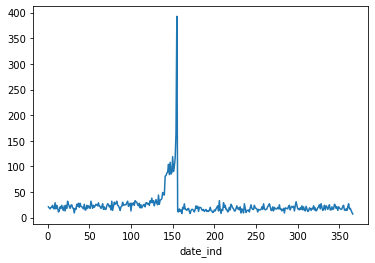

In [20]:
created_daily = pd.DataFrame({'date_ind': data.last_session_creation_time})
created_daily['sessions'] = 1
created_daily.date_ind = created_daily.date_ind.dt.dayofyear
created_daily.groupby('date_ind').sessions.sum().plot()

Interestingly we observe a spike in sessions midyear, corresponding to the most recent time in the dataset. This makes sense as a considerable subset of the users of our platform are likely actively using it.

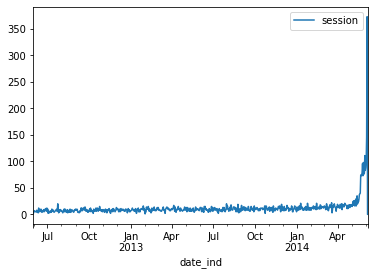

In [21]:
# Format to 1-hour increments
created = pd.DataFrame({'date_ind': data.last_session_creation_time})
created['session'] = 1
created.date_ind = pd.DatetimeIndex(created.date_ind)
created = created.set_index('date_ind')
created = created.groupby(pd.Grouper(freq='D')).sum()

created.plot()

We can observe this trend more clearly on the above graph. We may wish to create a variable for indivudals having used the platform in the past month.

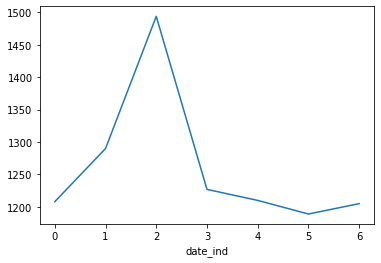

In [22]:
created_daily = pd.DataFrame({'date_ind': data.last_session_creation_time})
created_daily['sessions'] = 1
created_daily.date_ind = created_daily.date_ind.dt.dayofweek
created_daily.groupby('date_ind').sessions.sum().plot()

We also detect trends related to the day of week that the last session was created. 

## Account Creation

Text(0, 0.5, 'Logins')

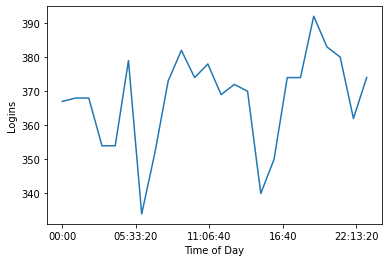

In [23]:
# Format to 1-hour increments
created = pd.DataFrame({'date_ind': data.creation_time})
created['session'] = 1
created.date_ind = pd.DatetimeIndex(created.date_ind)
created = created.set_index('date_ind')
created = created.groupby(pd.Grouper(freq='60min')).sum()

# # Reformat to aggregate of visits in this period
created = created.reset_index()
created.date_ind = created.date_ind.dt.time
created_hourly = created.groupby('date_ind').session.sum()
created_hourly.plot()

plt.xlabel('Time of Day')
plt.ylabel('Logins')

The graph for time of account creation mirrors that for last session very closely, prompting questions about how similar these two fields are.

In [24]:
data[['creation_time', 'last_session_creation_time']]

,creation_time,last_session_creation_time
0,2014-04-22 03:53:30,2014-04-22 03:53:30
1,2013-11-15 03:45:04,2014-03-31 03:45:04
2,2013-03-19 23:14:52,2013-03-19 23:14:52
3,2013-05-21 08:09:28,2013-05-22 08:09:28
4,2013-01-17 10:14:20,2013-01-22 10:14:20
...,...,...
8818,2013-09-06 06:14:15,2013-09-06 06:14:15
8819,2013-01-10 18:28:37,2013-01-15 18:28:37
8820,2014-04-27 12:45:16,2014-04-27 12:45:16
8821,2012-05-31 11:55:59,2012-06-02 11:55:59


In [25]:
data.creation_time = pd.to_datetime(data.creation_time)

In [26]:
sum(data.creation_time == data.last_session_creation_time)/len(data)

0.34308058483509013

Interestingly, 35% of the users in the dataset only logged in once (the time they created their account). This is useful information to catalogue.

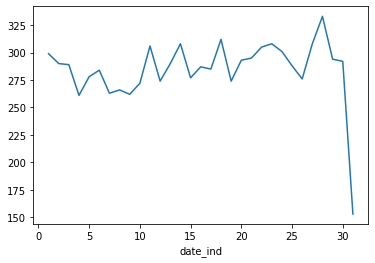

In [27]:
created_daily = pd.DataFrame({'date_ind': data.creation_time})
created_daily['sessions'] = 1
created_daily.date_ind = created_daily.date_ind.dt.day
created_daily.groupby('date_ind').sessions.sum().plot()

We can see that the time of month that the account was created seems to be relatively stable.

Text(0, 0.5, 'Logins')

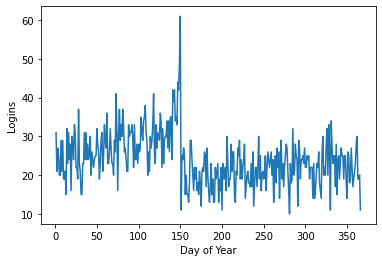

In [28]:
created_daily = pd.DataFrame({'date_ind': data.creation_time})
created_daily['sessions'] = 1
created_daily.date_ind = created_daily.date_ind.dt.dayofyear
created_daily.groupby('date_ind').sessions.sum().plot()
plt.xlabel('Day of Year')
plt.ylabel('Logins')

The day of year account was created is also fairly stable, though since the timeseries ends mid-year, there is a detectable bump.

Text(0, 0.5, 'Logins')

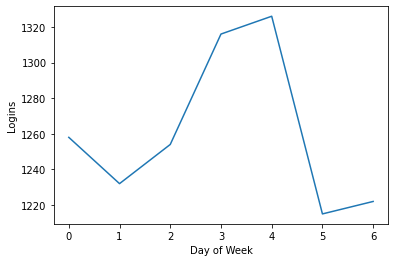

In [29]:
created_daily = pd.DataFrame({'date_ind': data.creation_time})
created_daily['sessions'] = 1
created_daily.date_ind = created_daily.date_ind.dt.dayofweek
created_daily.groupby('date_ind').sessions.sum().plot()
plt.xlabel('Day of Week')
plt.ylabel('Logins')

The day of week that the account was created shows interesting variation as well. We may wish to use this as a feature.

In [30]:
time_features = pd.DataFrame({'hr_created': data.creation_time.dt.hour,
                              'day_created': data.creation_time.dt.dayofyear,
                              'wkday_created': data.creation_time.dt.weekday,
                              'hr_last_session': data.last_session_creation_time.dt.hour,
                              'day_last_session': data.last_session_creation_time.dt.dayofyear,
                              'wkday_last_session': data.last_session_creation_time.dt.weekday,
                              'is_last_mo_session': data.last_session_creation_time > '2014-06-01',
                              'single_login': data.last_session_creation_time == data.creation_time})

time_features.head()

,hr_created,day_created,wkday_created,hr_last_session,day_last_session,wkday_last_session,is_last_mo_session,single_login
0,3,112,1,3,112,1,False,True
1,3,319,4,3,90,0,False,False
2,23,78,1,23,78,1,False,True
3,8,141,1,8,142,2,False,False
4,10,17,3,10,22,1,False,False


We can create a dataframe of time-based features from our main data. There is likely some room for improvement here. Many of these variables may be more usefully treated as binned or one-hot-encoded features, but for this relatively brief treatment of the data, we will encode them as continuous values and accept this caveat.

## Final Training Data Creation

In [31]:
outcome_vec = data.adopted
feature_data = pd.concat([data.drop(['creation_time', 
                                      'last_session_creation_time', 
                                      'email',
                                      'adopted',
                                      'creation_source'], axis=1),
                           email_dummies,
                           creation_source,
                           time_features],
                         axis=1)

feature_data.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,cuvox.de,gmail.com,gustr.com,hotmail.com,jourrapide.com,other,yahoo.com,GUEST_INVITE,...,SIGNUP,SIGNUP_GOOGLE_AUTH,hr_created,day_created,wkday_created,hr_last_session,day_last_session,wkday_last_session,is_last_mo_session,single_login
0,1,0,0,0,0,0,0,0,1,1,...,0,0,3,112,1,3,112,1,False,True
1,0,0,0,0,1,0,0,0,0,0,...,0,0,3,319,4,3,90,0,False,False
2,0,0,0,0,1,0,0,0,0,0,...,0,0,23,78,1,23,78,1,False,True
3,0,0,0,0,0,0,0,0,1,1,...,0,0,8,141,1,8,142,2,False,False
4,0,0,0,0,0,0,0,0,1,1,...,0,0,10,17,3,10,22,1,False,False


This gives us our final dataframe and outcome vector, which we will use for training our classifier.

# User Behavior Prediction

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_data,
                                                    outcome_vec,
                                                    test_size=0.2)

We create our training and test set from the data.

In [33]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=1, learning_rate=0.01)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.9507082152974504

Due to the sparsity of the data and prevalence of missing information, as well as a desire not to overfit to our training data, we select XGBoost for this classification task. This boosted tree-based approach has a great deal of power and is popular in various contexts.

The initial fit of the model does extremely well, correctly classifying 95% of individuals who are likely to become adopted users. We can investigate this with more detail to see what underlies the model's decisions.

F1 : [0.97099033 0.83615819]
Precision : [0.96296296 0.87747036]
Recall : [0.97915266 0.79856115]


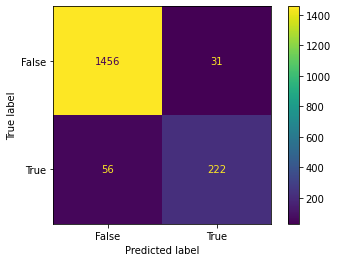

In [34]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, precision_score, recall_score, auc, roc_curve

predictions = xgb.predict(X_test)
Y_Testshaped = y_test.values

cm = confusion_matrix(Y_Testshaped, predictions)
print('F1 : ' + str(f1_score(Y_Testshaped, predictions, average=None)) )
print('Precision : ' + str(precision_score(Y_Testshaped, predictions, average=None)) )
print('Recall : ' + str(recall_score(Y_Testshaped, predictions, average=None)) )

plot_confusion_matrix(estimator=xgb, X=X_test, y_true=y_test)
plt.show()

When we consider these metrics, our accuracy rate begins to look less impressive. While the model is quite accomplished at classifying those unlikely to become an adopter, it struggles to identify the cases which are true positives, resulting in true positives and false negatives. This is reflected in the Precision and Recall scores, which hew closer to 80%.

In [35]:
from sklearn.utils import resample

# Separate majority and minority classes
feature_w_adpt = feature_data.copy()
feature_w_adpt['outcome'] = outcome_vec

df_majority = feature_w_adpt[outcome_vec]
df_minority = feature_w_adpt[~outcome_vec]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=3000,  
                                 random_state=123)
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In order to attempt to combat this problem we can attempt to upsample the number of adopting riders in the dataset.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_upsampled.drop(['outcome'],axis=1),
                                                    df_upsampled.outcome,
                                                    test_size=0.2)

xgb = XGBClassifier(random_state=1, learning_rate=0.01)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.9337209302325581

We again achieve nearly 95% accuracy, though we see a small downtick compared to the previous model's accuracy.

F1 : [0.95073466 0.89875666]
Precision : [0.94991364 0.90035587]
Recall : [0.95155709 0.89716312]


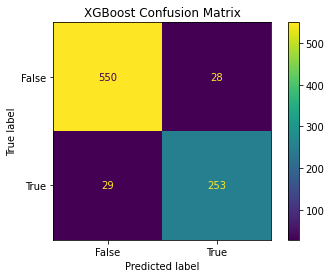

In [37]:
predictions = xgb.predict(X_test)
Y_Testshaped = y_test.values

cm = confusion_matrix(Y_Testshaped, predictions)
print('F1 : ' + str(f1_score(Y_Testshaped, predictions, average=None)) )
print('Precision : ' + str(precision_score(Y_Testshaped, predictions, average=None)) )
print('Recall : ' + str(recall_score(Y_Testshaped, predictions, average=None)) )

plot_confusion_matrix(estimator=xgb, X=X_test, y_true=y_test)
plt.title('XGBoost Confusion Matrix')
plt.show()

We see that upsampling the data did indeed help our ability to detect true positives, cutting our false positive and false negative rates substantially. 

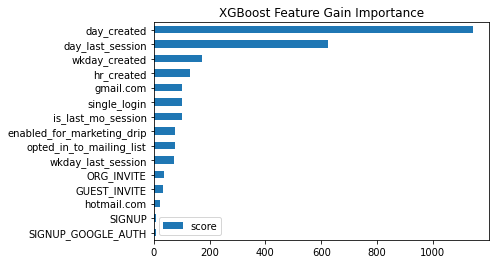

In [38]:
feature_import = xgb.get_booster().get_score(importance_type='weight')
(pd.DataFrame(data=feature_import.values(),
             index=feature_import.keys(),
             columns=['score'])
 .sort_values(by='score')
 .plot(kind='barh'))

plt.title('XGBoost Feature Gain Importance')
plt.show()

We can investigate the resulting feature importance scores from the XGBoost classifier to see how it made its decisions. Interestingly the day of year that the account was created seems to be highly predictive. We are unable to interrogate the specifics of this variable due to the nature of importance scores, but it seems to be a strong indicator that individuals who are using the service more frequently are more likely to be adopted users. This is not surprising, but can serve as a rationale to incentivize increased usage of the application, perhaps by providing more training resources or attempting to boost user engagement.

We also see other time-sensitive features represented, including whether a user only logged into the service once and whether their latest session was in the last month. It is likely that there is some leakage between these features, since it is possible to detect users who have logged into the application in a matter of days. This evidence seems to support the importance of this singular behavior.

Of the behavioral variables, opting into the mailing list appears to have had the largest effect, while the creation_source seems to have little effect, with all possible options relatively similar in importance.

Based on these findings, I would recommend a user engagement based approach to improving adoption of the application, and timed staging of promotions to best capitalize on user habits.